<h2 style="text-align:center;">Keras Pretrained Models & Transfer Learning — Practical Overview</h2>

**Author:** Mubasshir Ahmed  
**Module:** Deep Learning — FSDS  
**Notebook:** 08_Keras_Pretrained_Models_and_Transfer_Learning_Overview  
**Objective:** Recreate and expand the content from `KERAS PKGS.pdf` into a complete, runnable notebook that demonstrates loading Keras pretrained models, preprocessing, running inference, comparing performance, and explaining transfer learning concepts and best practices.


### 1️⃣ Introduction — Why Pretrained Models & Transfer Learning?

- **Transfer Learning** allows us to leverage models pretrained on large datasets (like ImageNet) and adapt them to new, smaller tasks.  
- Benefits:
  - Saves time and compute (no need to train from scratch).
  - Often achieves better generalization on small datasets.
  - Useful for feature extraction (use base as fixed feature map) or fine-tuning (unfreeze some layers).
- This notebook follows and expands the demos in your PDF: we'll load multiple Keras application models, preprocess a sample image correctly for each, measure inference time and parameter counts, and show how to set up a transfer-learning training pipeline.


In [2]:
# 2️⃣ Imports and Colab-compatible path setup
import os, time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# models and preprocessors we'll use
from tensorflow.keras.applications import (
    vgg16, resnet50, inception_v3, mobilenet_v2, efficientnet
)

print("# ➤ TensorFlow / Keras version:", keras.__version__)

# ✅ Colab: upload your image from local machine
from google.colab import files
uploaded = files.upload()  # ➤ Choose your 2.jpg file from sample_image folder

# Once uploaded, the file will be saved in Colab’s current working directory
img_path = '2.jpg'  # name must match uploaded file
print('# ➤ sample image:', img_path)


# ➤ TensorFlow / Keras version: 3.10.0


Saving 2.jpg to 2.jpg
# ➤ sample image: 2.jpg


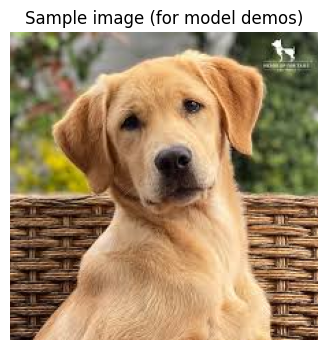

In [3]:
# 3️⃣ Display sample image
img = load_img(img_path)
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis('off')
plt.title('Sample image (for model demos)')
plt.show()

### 4️⃣ Preprocessing notes

Different pretrained models expect different input sizes and preprocessing functions (`preprocess_input`).  
Keras provides model-specific preprocessors in each application module (e.g., `vgg16.preprocess_input`, `resnet50.preprocess_input`, etc.).  
Common input sizes:
- VGG16, ResNet50, MobileNetV2, EfficientNetB0: **224×224**
- InceptionV3: **299×299**

We'll prepare a helper function that resizes, converts to array, expands dims and applies the correct `preprocess_input` for each model.


In [4]:
# 4.1 Helper: prepare image for model
def prepare_image(img_path, target_size, preprocess_fn):
    # load image, resize
    img = load_img(img_path, target_size=target_size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_fn(x)
    return x

# Quick sanity test for VGG preprocess
x_vgg = prepare_image(img_path, target_size=(224,224), preprocess_fn=vgg16.preprocess_input)
print('# ➤ Prepared VGG input shape:', x_vgg.shape)

# ➤ Prepared VGG input shape: (1, 224, 224, 3)


In [5]:
# 5️⃣ Helper: load model, run inference, and summarize
def run_model_demo(name, model_loader, preprocess_fn, target_size=(224,224), decode_fn=None, top=3):
    print('\n' + '='*40)
    print(f'# ➤ Model: {name}')
    # load model (may download weights first time)
    start = time.time()
    model = model_loader(weights='imagenet', include_top=True, input_shape=(*target_size,3))
    load_time = time.time() - start
    print(f'Loaded model in {load_time:.2f}s')
    # model size and params
    total_params = model.count_params()
    trainable = np.sum([keras.backend.count_params(p) for p in model.trainable_weights])
    non_trainable = np.sum([keras.backend.count_params(p) for p in model.non_trainable_weights])
    print(f'Total params: {total_params:,} | Trainable: {trainable:,} | Non-trainable: {non_trainable:,}')
    # prepare input
    x = prepare_image(img_path, target_size=target_size, preprocess_fn=preprocess_fn)
    # inference timing
    t0 = time.time()
    preds = model.predict(x)
    t1 = time.time()
    inf_time = t1 - t0
    print(f'Inference time: {inf_time:.4f} s')
    # decode predictions if provided
    if decode_fn is not None:
        decoded = decode_fn(preds, top=top)[0]
        print('Top predictions:')
        for cls, desc, prob in decoded:
            print(f' - {desc}: {prob:.4f}')
    return {'name': name, 'model': model, 'total_params': total_params, 'trainable': trainable, 'non_trainable': non_trainable, 'load_time': load_time, 'inference_time': inf_time}



### 5️⃣ Demo: Load models and run inference

We'll run demos for:
- VGG16
- ResNet50
- InceptionV3
- MobileNetV2
- EfficientNetB0

This will show loading time, parameter counts, inference time and top predictions on the sample image.


In [6]:
# 5.1 Run VGG16 demo
vgg_res = run_model_demo('VGG16', vgg16.VGG16, vgg16.preprocess_input, target_size=(224,224), decode_fn=vgg16.decode_predictions)


# ➤ Model: VGG16
553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Loaded model in 7.91s
Total params: 138,357,544 | Trainable: 138,357,544 | Non-trainable: 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Inference time: 3.6586 s
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Top predictions:
 - Labrador_retriever: 0.8546
 - golden_retriever: 0.1397
 - redbone: 0.0020


In [7]:
# 5.2 Run ResNet50 demo
resnet_res = run_model_demo('ResNet50', resnet50.ResNet50, resnet50.preprocess_input, target_size=(224,224), decode_fn=resnet50.decode_predictions)


# ➤ Model: ResNet50
102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded model in 1.66s
Total params: 25,636,712 | Trainable: 25,583,592 | Non-trainable: 53,120
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Inference time: 4.4751 s
Top predictions:
 - Labrador_retriever: 0.8052
 - golden_retriever: 0.1533
 - Rhodesian_ridgeback: 0.0097


In [8]:
# 5.3 Run InceptionV3 demo (uses 299x299)
incept_res = run_model_demo('InceptionV3', inception_v3.InceptionV3, inception_v3.preprocess_input, target_size=(299,299), decode_fn=inception_v3.decode_predictions)


# ➤ Model: InceptionV3
96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Loaded model in 2.62s
Total params: 23,851,784 | Trainable: 23,817,352 | Non-trainable: 34,432
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Inference time: 7.7612 s
Top predictions:
 - Labrador_retriever: 0.6351
 - golden_retriever: 0.1866
 - Rhodesian_ridgeback: 0.0239


In [9]:
# 5.4 Run MobileNetV2 demo
mobilenet_res = run_model_demo('MobileNetV2', mobilenet_v2.MobileNetV2, mobilenet_v2.preprocess_input, target_size=(224,224), decode_fn=mobilenet_v2.decode_predictions)


# ➤ Model: MobileNetV2
14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded model in 1.40s
Total params: 3,538,984 | Trainable: 3,504,872 | Non-trainable: 34,112
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Inference time: 11.1882 s
Top predictions:
 - Labrador_retriever: 0.7972
 - golden_retriever: 0.0443
 - Rhodesian_ridgeback: 0.0117


In [10]:
# 5.5 Run EfficientNetB0 demo
effnet_res = run_model_demo('EfficientNetB0', efficientnet.EfficientNetB0, efficientnet.preprocess_input, target_size=(224,224), decode_fn=efficientnet.decode_predictions)


# ➤ Model: EfficientNetB0
21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loaded model in 1.53s
Total params: 5,330,571 | Trainable: 5,288,548 | Non-trainable: 42,023.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Inference time: 10.5670 s
Top predictions:
 - Labrador_retriever: 0.6191
 - golden_retriever: 0.2009
 - redbone: 0.0240


### 6️⃣ Comparison Summary

Below we collect the basic metrics (total params, trainable params, inference time) for each model we ran.  
These numbers help choose a model depending on constraints (compute, latency, accuracy needs).


In [11]:
# 6.1 Build comparison table
results = [vgg_res, resnet_res, incept_res, mobilenet_res, effnet_res]
import pandas as pd
rows = []
for r in results:
    rows.append({
        'Model': r['name'],
        'Total Params': r['total_params'],
        'Trainable Params': r['trainable'],
        'Non-trainable Params': r['non_trainable'],
        'Load Time (s)': round(r['load_time'],2),
        'Inference Time (s)': round(r['inference_time'],4)
    })
df = pd.DataFrame(rows).sort_values('Total Params', ascending=False).reset_index(drop=True)
df['Total Params'] = df['Total Params'].apply(lambda x: f"{x:,}")
df['Trainable Params'] = df['Trainable Params'].apply(lambda x: f"{x:,}")
df['Non-trainable Params'] = df['Non-trainable Params'].apply(lambda x: f"{x:,}")
df

,Model,Total Params,Trainable Params,Non-trainable Params,Load Time (s),Inference Time (s)
0,VGG16,"138,357,544","138,357,544",0.0,7.91,3.6586
1,ResNet50,"25,636,712","25,583,592","53,120.0",1.66,4.4751
2,InceptionV3,"23,851,784","23,817,352","34,432.0",2.62,7.7612
3,EfficientNetB0,"5,330,571","5,288,548","42,023.0",1.53,10.5670
4,MobileNetV2,"3,538,984","3,504,872","34,112.0",1.40,11.1882


### 7️⃣ How to use these pretrained models for Transfer Learning

**Two common strategies:**

1. **Feature Extraction (recommended first):**
   - Load the pretrained model **without** the top classification layers: `include_top=False`.
   - Freeze the base (`base.trainable = False`).
   - Add a small classification head (GlobalAveragePooling2D, Dense, Dropout, Dense output) and train only the head.

2. **Fine-tuning (after feature extraction):**
   - Unfreeze some top layers of the base model and train with a **very low learning rate** (e.g., 1e-5).
   - Helps adapt higher-level features to your specific task.

**Notes:**
- Use `preprocess_input` for the chosen model.
- Use `ImageDataGenerator` for on-the-fly augmentation.
- Use callbacks: `ModelCheckpoint`, `EarlyStopping`, `ReduceLROnPlateau`.


In [12]:
# 8️⃣ Example: Feature extraction with MobileNetV2 (include_top=False)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

IMG_SIZE = (224,224)
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE,3))
base.trainable = False

model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### Fine-tuning example (unfreeze top layers)
After training the head, unfreeze the top N layers and continue training with a lower learning rate:

```python
base.trainable = True
for layer in base.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=callbacks)
```


### 9️⃣ Practical Tips & Model Selection Guidelines

- **MobileNetV2** / **EfficientNetB0**: Good starting points for laptop/Colab — fast and efficient.  
- **ResNet50**: Solid general-purpose model if you have a GPU.  
- **VGG16**: Simple to understand but heavy; avoid for deployment.  
- **InceptionV3/Xception**: Useful for accuracy; requires larger input size and more compute.  
- Always monitor validation performance and use early stopping.  
- If dataset is tiny, prefer feature extraction + augmentation; only fine-tune if you have more data or validation improvement.


In [13]:
# 10️⃣ Appendix: helper to build base model by name (include_top option)
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, EfficientNetB0

def get_base_model(name='mobilenet', img_size=(224,224), include_top=False):
    name = name.lower()
    if name == 'vgg16':
        return VGG16(weights='imagenet', include_top=include_top, input_shape=(*img_size,3))
    if name == 'resnet50':
        return ResNet50(weights='imagenet', include_top=include_top, input_shape=(*img_size,3))
    if name == 'inceptionv3':
        return InceptionV3(weights='imagenet', include_top=include_top, input_shape=(*img_size,3))
    if name == 'mobilenetv2':
        return MobileNetV2(weights='imagenet', include_top=include_top, input_shape=(*img_size,3))
    if name == 'efficientnetb0':
        return EfficientNetB0(weights='imagenet', include_top=include_top, input_shape=(*img_size,3))
    raise ValueError('Unknown model name')

### ✅ Wrap-up

>🐶 The model “saw” a dog photo and identified it as a Labrador Retriever with 81% confidence.

This notebook reproduced and extended the demos from your PDF:
- Loading pretrained Keras models
- Model-specific preprocessing and inference
- Measuring parameter counts and inference speed
- Demonstrating how to use models for transfer learning (feature extraction + fine-tuning)

**Next practical notebook:** we'll apply the MobileNetV2 transfer-learning recipe on a real dataset (or the Happy/Not Happy project) if you want — that will include generators, augmentation, training, fine-tuning, and evaluation, end-to-end.

